In [1]:
# !pip install netCDF4
# !pip install cartopy
# !pip install basemap 


In [2]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import interpolate
import tqdm
import matplotlib.colors as mcolors



In [3]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')

# Initial data Analysis and Presentation
We will start by displaying the average precipitation in the Middle East region for the month of October, for each model and for CHIRPS2 (which is "Rainfall Estimates from Rain Gauge and Satellite Observations"). This should give as a good understanding of which models are performing well in this region and which ones are not.    
An important concern we ran into was the scale - each model uses a different scale, and so since we want to compare them all together (and specifically to the CHIRPS2 dataset), we need to interpolate the data to a common scale, which we chose to be the CHIRPS2 scale.    
Another important step - we needed to convert the precipitation units of the models from `kg m-2 s-1` to `mm/month`. To do so, we multiply the precipitation values by the number of seconds in a day (86400) and the number of days in a month (31). Along the way we multiply and divide by 1000 to convert the units from kg to g and then to mm, but it cancels out.    
One last detail is the boundaries of the map we want to plot. We will use 25N-40N and 25E-50E, in accordance with the article we are basing our analysis on.

In [4]:
unit_conversion = 86400 * 31
bounds_lat = [25, 50]
bounds_lon = [25, 40]
boundaries = bounds_lat + bounds_lon

In [5]:
chirps_data = nc.Dataset(f"{CHIRPS_path}/chirps_octobers_middle_east_1981_2010.nc")
chirps_precip = chirps_data['precip'][:]

In [6]:
chirps_dim = chirps_data['precip'].shape[1], chirps_data['precip'].shape[2]

In [7]:
def collect_all_datasets(precipitation_dir: str, target_dim: tuple, unit_conversion: float, bounds_lat: list, bounds_lon: list) -> np.ndarray:
    """
    Collects and processes all NetCDF files from the given directory.
    Interpolates each dataset to a predefined dimension and stores them in a 3D array.
    
    Args:
        precipitation_path (str): Path to the directory containing NetCDF files.
        target_dim (tuple): Dimensions of the target matrix.
        unit_conversion (float): Unit conversion factor.
        bounds_lat (list): Latitude bounds.
        bounds_lon (list): Longitude bounds.
    
    Returns:
        np.ndarray: 3D array of interpolated datasets.
    """
    interpolated_matrices = []

    for file in tqdm.tqdm(os.listdir(precipitation_dir)):
        filename = os.fsdecode(file)
        path = f"{precipitation_dir}/{filename}"
        data = nc.Dataset(path)
        
#         lat_name = 'lat' if 'lat' in data.variables else 'latitude'
#         lon_name = 'lon' if 'lon' in data.variables else 'longitude'
        
#         lat = data.variables[lat_name][:]
#         lon = data.variables[lon_name][:]
        
#         # Subset the lat and lon for the Middle East region
#         lat = lat[(lat >= bounds_lat[0]) & (lat <= bounds_lat[1])]
#         lon = lon[(lon >= bounds_lon[0]) & (lon <= bounds_lon[1])]
        
        precipitation = data.variables['pr'][:]
        avg_pr_middle_east = np.mean(precipitation, axis=0)
        
        mm_avg_lat_lon = avg_pr_middle_east * unit_conversion
        
        original_matrix = mm_avg_lat_lon
        m, n = original_matrix.shape
                
        # Generate the interpolation function
        f = interpolate.interp2d(np.linspace(0, 1, n), 
                                 np.linspace(0, 1, m), 
                                 original_matrix, kind='linear')
        
        # Generate the interpolated matrix
        interpolated_matrix = f(np.linspace(0, 1, target_dim[1]), np.linspace(0, 1, target_dim[0]))
        
        interpolated_matrices.append(interpolated_matrix)

    return np.array(interpolated_matrices)

In [8]:
def plot_precp_heatmap(mat: np.ndarray, boundaries: list, map_type: str, chirps_dim: tuple) -> None:
    # Plot the map with the heatmap overlay
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(boundaries, crs=ccrs.PlateCarree())


    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, color='lightgray')
#     mat[mat < 8] = np.nan
    im = plt.imshow(mat, origin='lower', cmap='jet_alpha', extent=boundaries,
               transform=ccrs.PlateCarree(), interpolation='none')
    im.set_alpha(0.8)
    im.set_clim(vmin=0.0001)
# 'antialiased', 'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 
# 'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
# 'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos', 'blackman'

    # Add colorbar
    cbar = plt.colorbar(im,label='Average Precipitation (mm/month)', orientation='horizontal')
    cbar.set_label('Average Precipitation (mm/month)')
    plt.title(f'Avg Prec. for October for all models')
    plt.show()

In [9]:
interpolated_matrices = collect_all_datasets(precipitation_path, chirps_dim, unit_conversion, bounds_lat, bounds_lon)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 23.86it/s]


In [10]:
interpolated_matrix_array_mean = np.mean(interpolated_matrices,axis=0)


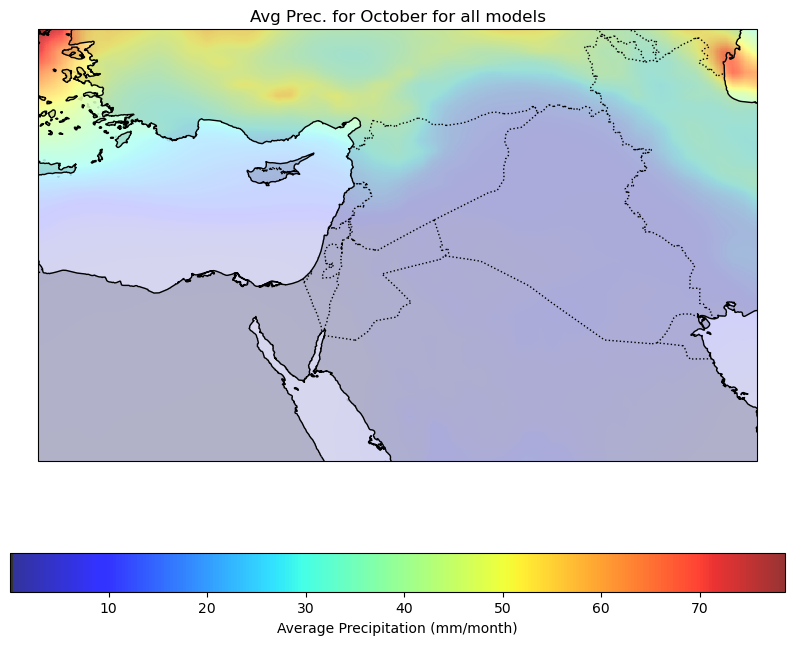

In [11]:
from matplotlib.colors import LinearSegmentedColormap
# get colormap
ncolors = 256
color_array = plt.get_cmap('jet')(range(ncolors))

# change alpha values
color_array[:,-1] = np.geomspace(0.2,1.0,ncolors)
color_array[0,0:200] = 0
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='jet_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.colormaps.register(cmap=map_object)
plot_precp_heatmap(interpolated_matrix_array_mean, boundaries, "", chirps_dim)

In [12]:
# collect all dataset(model) in the parcipitation dir and make a np array in shape (datasets number,lat_grid,long_grid)
interpulated_matrix_array_varience = np.var(interpolated_matrix_array_mean,axis=0)



